<a href="https://colab.research.google.com/github/yatindma/Automated-Response-Suggestion-for-Email/blob/master/Smart_reply_suggestion_multiclassification_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Smart Email Reply Suggestion**

Email is one of the most popular modes of communication on the Web. Despite the recent increase in usage of
social networks, email continues to be the primary medium
for billions of users across the world to connect and share
information. With the rapid increase in email overload, it
has become increasingly challenging for users to process and
respond to incoming messages. It can be especially time consuming to type email replies on a mobile device so to over come this solution we need to suggest some basic replies to the users so that it can be fast and convinient to reply an email <br><br>


This is an end to end method to automatically generating short email responses. It generates semantically diverse suggestions that can be used as complete email responses. The system is currently used in Inbox by Gmail and is responsible for assisting with 10% of
all mobile responses. <br>
[Google smart reply suggestions](https://arxiv.org/pdf/1606.04870.pdf)


In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import os
from  tqdm import tqdm 
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [15]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

**Regarding Dataset**

The dataset which I am using is from multiple sources <br>[dataset link1](https://github.com/gabrielfarah/QA_Bot/blob/master/qa_dataset.csv)<br>
[dataset link2](https://github.com/gabrielfarah/QA_Bot/blob/master/qa_dataset.csv)<br>
[dataset link3](https://github.com/gabrielfarah/QA_Bot/blob/master/qa_dataset.csv)<br>

This dataset contain small replies and later we cleaned some of the data as per the requirement.

#Reading the data

In [ ]:
import json
arr = []
question = []
answer = []
with open("data/train_data.txt","rb") as json_file:
    data = json.load(json_file)
    for data_ in data['data']:
        for j,para in enumerate(data_['paragraphs']):
          for k,qas in enumerate(para['qas']):
            for ans in qas['answers']:
              answer.append(ans['text'])
              question.append(qas['question'])  
              break
        


In [ ]:
df = pd.DataFrame(list(zip(question, answer)), 
               columns =['question', 'reply']) 

In [ ]:
df.tail(3)

,question,reply
86818,With what Belorussian city does Kathmandu have...,Minsk
86819,In what year did Kathmandu create its initial ...,1975
86820,What is KMC an initialism of?,Kathmandu Metropolitan City


In [ ]:
#Add more data to the above data 
df2 = pd.read_csv("data/qa_dataset.csv", encoding = "ISO-8859-1", low_memory=False)

In [ ]:
df2.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Alessandro_Volta,Was Volta an Italian physicist?,yes,easy,easy,data/set4/a10
1,Alessandro_Volta,Is Volta buried in the city of Pittsburgh?,no,easy,easy,data/set4/a10


In [ ]:
#Drop the columns which we don' need 
df2 = df2.drop(['ArticleTitle','DifficultyFromQuestioner','DifficultyFromAnswerer','ArticleFile'],axis =1 ) 
df2.columns = ['question', 'reply']

In [ ]:
df3 = pd.read_csv("data/music_questions.csv")
df3.columns = ['q','question', 'reply']
df3.drop(['q'],axis = 1).head(2)

,question,reply
0,how long is this cord? the pictures looks like...,I took a photo: <http://imgur.com/G48f1C4>I bo...
1,Has anyone used this to split a stereo signal?...,I believe this adapter yields a mono split and...


In [ ]:
df4 = pd.read_csv("data/grocery_questions.csv")
df4.columns = ['q','question', 'reply']
df4.drop(['q'],axis = 1).head(2)

,question,reply
0,what are the colors that come in the package?,"All colors seen on box plus Teal, Burgundy, Bl..."
1,difference between meat cure and pickling salt,Pickling salt is a very pure form of salt. A m...


In [ ]:
df5 = pd.read_csv("data/video_game_qa.csv")
df5.columns = ['q','question', 'reply']
df5.drop(['q'],axis = 1).head(2)

,question,reply
0,"Yes, you will need to go to their website to d...","Yes, you will need to go to their website to d..."
1,As long as it has a USB port it should work fi...,As long as it has a USB port it should work fi...


In [ ]:
df2.shape

(2917, 2)

In [ ]:
df.shape

(86821, 2)

In [ ]:
df3.shape

(2976, 3)

In [ ]:
df4.shape

(2997, 3)

In [ ]:
df5.shape

(1183, 3)

In [ ]:
#Append both the dataset

frames = [df, df2,df3,df4,df5]
data = pd.concat(frames)

In [ ]:
data.shape

(96894, 3)

In [ ]:
data.size

290682

In [ ]:
data.tail(2)

,question,reply,q
1181,You can use it to replace the sticks on the ps...,You can use it to replace the sticks on the ps...,1181.0
1182,"it will work on macs, i got euro truck sim to ...","it will work on macs, i got euro truck sim to ...",1182.0


In [ ]:
data.shape

(96894, 3)

So we have nearly 90K data points 

#Data Cleaning and EDA

**Converting data into lower case**

In [ ]:
data = data.apply(lambda x: x.astype(str).str.lower())
data.head(4)

,question,reply,q
0,when did beyonce start becoming popular?,in the late 1990s,nan
1,what areas did beyonce compete in when she was...,singing and dancing,nan
2,when did beyonce leave destiny's child and bec...,2003,nan
3,in what city and state did beyonce grow up?,"houston, texas",nan


**Removing all special characters from the data**

Removing the stop words from the questions

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
data.head()

,question,reply,q
0,when did beyonce start becoming popular?,in the late 1990s,nan
1,what areas did beyonce compete in when she was...,singing and dancing,nan
2,when did beyonce leave destiny's child and bec...,2003,nan
3,in what city and state did beyonce grow up?,"houston, texas",nan
4,in which decade did beyonce become famous?,late 1990s,nan


In [ ]:
from tqdm import tqdm
all_questions= []
for sentence in tqdm(data['question'].values): 
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    # sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)   
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    all_questions.append(sentence.strip())

 99%|█████████▉| 96254/96894 [00:41<00:00, 2336.70it/s]C:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:337: MarkupResemblesLocatorWarning: "...." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 96894/96894 [00:42<00:00, 2290.20it/s]


In [ ]:
#Putting all preprocessed data back to the dataframe
data['question'] = all_questions

We need to delete the data where Answers are not correct 


In [ ]:
all_replies= []
for sentence in tqdm(data['reply'].values): 
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)   
    all_replies.append(sentence.strip())

100%|██████████| 96894/96894 [00:01<00:00, 48680.90it/s]


**Trimming the data**

In [ ]:
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

Here we'll not drop the duplicate question as we'll be using they will help us in getting multiple replies

In [ ]:
data.shape

(96894, 3)

In [ ]:
#get the length of the replies
len_str_arr = []
for sentence in data["reply"].values:
  len_str_arr.append(len(sentence.split()))



data["reply_length"]= len_str_arr

data = data[(data.reply_length < 8)]
print(data.head())


len_str_arr_quest = []
for sentence in data["question"].values:
  len_str_arr_quest.append(len(sentence.split()))


data['question_length'] = len_str_arr_quest 
data = data[data.question_length < 100]
print(data.size)

                                            question                reply  \
0            when did beyonce start becoming popular    in the late 1990s   
1  what areas did beyonce compete in when she was...  singing and dancing   
2  when did beyonce leave destiny s child and bec...                 2003   
3         in what city and state did beyonce grow up       houston, texas   
4          in which decade did beyonce become famous           late 1990s   

     q  reply_length  
0  nan             4  
1  nan             3  
2  nan             1  
3  nan             2  
4  nan             2  
417415


We'll only take those reply only where the length is greater than 0 

In [ ]:
data = data[(data.reply_length > 0)]

In [ ]:
data.shape

(83483, 5)

**We need to remove replies where grammer is not correct**

In [ ]:
#Code is copied form https://www.geeksforgeeks.org/check-given-sentence-given-set-simple-grammer-rules/
# Method to check a given sentence for given rules 
def checkSentence(string): 
  
    # Calculate the length of the string. 
    length = len(string) 
  
    # Check that the first character lies in [A-Z]. 
    # Otherwise return false. 
    if string[0] < 'A' or string[0] > 'Z': 
        return False
  
    # Maintain 2 states. Previous and current state based 
    # on which vertex state you are. Initialise both with 
    # 0 = start state. 
    prev_state = 0
    curr_state = 0
  
    # Keep the index to the next character in the string. 
    index = 1
  
    # Loop to go over the string. 
    while (string[index]): 
        # Set states according to the input characters in the 
        # string and the rule defined in the description. 
        # If current character is [A-Z]. Set current state as 0. 
        # if string[index] >= 'A' and string[index] <= 'Z': 
        #     curr_state = 0
  
        # If current character is a space. Set current state as 1. 
        if string[index] == ' ': 
            curr_state = 1
  
        # If current character is a space. Set current state as 2. 
        elif string[index] >= 'a' and string[index] <= 'z': 
            curr_state = 2
  
        # If current character is a space. Set current state as 3. 
        elif string[index] == '.': 
            curr_state = 3
  
        # Validates all current state with previous state for the 
        # rules in the description of the problem. 
        if prev_state == curr_state and curr_state != 2: 
            return False
  
        # If we have reached last state and previous state is not 1, 
        # then check next character. If next character is '\0', then 
        # return true, else false 
        if prev_state == 2 and curr_state == 0: 
            return False
  
        # Set previous state as current state before going over 
        # to the next character. 
        if curr_state == 3 and prev_state != 1: 
            return True
  
        index += 1
  
        prev_state = curr_state 
  
    return False

In [ ]:
string = data['reply'].values
string_size = len(string) 
grammar = []
count = 0
for i in range(string_size): 
    if checkSentence(string[i]): 
      grammar.append(1)
      count+=1
    else: 
      grammar.append(0)

In [ ]:
count # as here the count depict that out data is not coorect according to grammar

0

the above approach for checking grammar is not working for this data set

We need to change the approach to take where grammar is good

We didn't dopped more data :)

#Select only replies which are having more than 3 repetition in the dataset 

In [ ]:
# Python3 program to find number of 
# times a string appears in an array. 

repeated_count = []
# Returns count of occurrences of s in arr[] 
def search(arr, s): 
	counter = 0
	for j in (range(len(arr))): 
		
		# checking if string given in query 
		# is present in the given string. 
		# If present, increase times 
		if (s == (arr[j])): 
			counter += 1

	return counter 

def answerQueries(arr, q): 
	for i in tqdm(range(len(q))): 
		repeated_count.append(search(arr, q[i]))

# Driver code /
if __name__ == '__main__': 
	arr = data['reply'].values 
	q = data['reply'].values 
	answerQueries(arr, q) 

# This code is contributed 
# by PrinciRaj19992 from github


100%|██████████| 83483/83483 [18:24<00:00, 75.57it/s]


In [ ]:
count = 0
for item in repeated_count:
  if item > 0:
    count += 1

print("total replies, repeated as well as not repeated ",count)

count = 0
for item in repeated_count:
  if item > 1:
    count += 1

print("total replies more than 1",count)

count = 0
for item in repeated_count:
  if item > 2:
    count += 1

print("total replies more than 2",count)

count = 0
for item in repeated_count:
  if item > 3:
    count += 1

print("total replies more than 3",count)

count = 0
for item in repeated_count:
  if item > 4:
    count += 1

print("total replies more than 4",count)

count = 0
for item in repeated_count:
  if item > 5:
    count += 1

print("total replies more than 5",count)

count = 0
for item in repeated_count:
  if item > 6:
    count += 1

print("total replies more than 6",count)


count = 0
for item in repeated_count:
  if item > 7:
    count += 1

print("total replies more than 7",count)

count = 0
for item in repeated_count:
  if item > 11:
    count += 1

print("total replies more than 11",count)

count = 0
for item in repeated_count:
  if item > 15:
    count += 1

print("total replies more than 15",count)


count = 0
for item in repeated_count:
  if item > 16:
    count += 1

print("total replies more than 16",count)



count = 0
for item in repeated_count:
  if item > 17:
    count += 1

print("total replies more than 17",count)



count = 0
for item in repeated_count:
  if item > 18:
    count += 1

print("total replies more than 18",count)



count = 0
for item in repeated_count:
  if item > 19:
    count += 1

print("total replies more than 19",count)

count = 0
for item in repeated_count:
  if item > 20:
    count += 1
print("total replies more than 20",count)

count = 0
for item in repeated_count:
  if item > 21:
    count += 1
print("total replies more than 21",count)    

count = 0
for item in repeated_count:
  if item > 22:
    count += 1
print("total replies more than 22",count)

count = 0
for item in repeated_count:
  if item > 23:
    count += 1

print("total replies more than 23",count)

total replies, repeated as well as not repeated  83483
total replies more than 1 32638
total replies more than 2 23112
total replies more than 3 19053
total replies more than 4 16725
total replies more than 5 15105
total replies more than 6 13863
total replies more than 7 13037
total replies more than 11 10351
total replies more than 15 8737
total replies more than 16 8465
total replies more than 17 8176
total replies more than 18 7798
total replies more than 19 7456
total replies more than 20 7176
total replies more than 21 6966
total replies more than 22 6790
total replies more than 23 6560


So we'll be selecting replies which are repeated more than 20 times<br>
as mostly they will be correct as they are repeated multiple times

In [ ]:
data['repeated_reply_count'] = repeated_count

In [ ]:
data.head()

,q,question,reply,reply_length,question_length,repeated_reply_count
0,nan,when did beyonce start becoming popular,in the late 1990s,4,6,1
1,nan,what areas did beyonce compete in when she was...,singing and dancing,3,11,1
2,nan,when did beyonce leave destiny s child and bec...,2003,1,12,47
3,nan,in what city and state did beyonce grow up,"houston, texas",2,9,1
4,nan,in which decade did beyonce become famous,late 1990s,2,7,5


In [ ]:
data_new_15 = data[data.repeated_reply_count > 20]

In [ ]:
data = data_new_15

In [ ]:
data.head(5)

,question,reply,q,reply_length,question_length,repeated_reply_count
2,when did beyonce leave destiny s child and bec...,2003,nan,1,12,47
11,when did beyonc release dangerously in love,2003,nan,1,7,47
12,how many grammy awards did beyonc win for her ...,five,nan,1,12,140
17,to set the record for grammys how many did bey...,six,nan,1,11,99
19,when did beyonce take a hiatus in her career a...,2010,nan,1,15,75


Checking number of unique replies in the data 

In [ ]:
unique_replies = (data_new_15.reply.unique())

In [ ]:
total_unique_replies = len(unique_replies)

In [ ]:
print(total_unique_replies)

155


Let see which are top repeated replies 

In [ ]:
reply_list = list(data['reply'].values)
reply_dict = {i:reply_list.count(i) for i in reply_list}

In [ ]:
from collections import OrderedDict
reply_dict_sorted = OrderedDict(sorted(reply_dict.items(), key=lambda x: x[1]))

In [ ]:
reply = []
keys = []
for item in reply_dict_sorted.items():
  reply.append(item[0])
  keys.append(item[1])

In [ ]:
reply.reverse()
keys.reverse()

In [ ]:
#top 10 reply
top_15_reply = reply[:15]
top_15_keys = keys[:15]

In [ ]:
temp_reply_list = []
i = 0
for key in top_15_keys:
  for _ in range(0,key):
    temp_reply_list.append(top_15_reply[i])
  i += 1

<b>
Article title can be used while giving the sentence for tokenizing later 
question do we need to preprocess the data
reply mai kitne repeated h
</b>


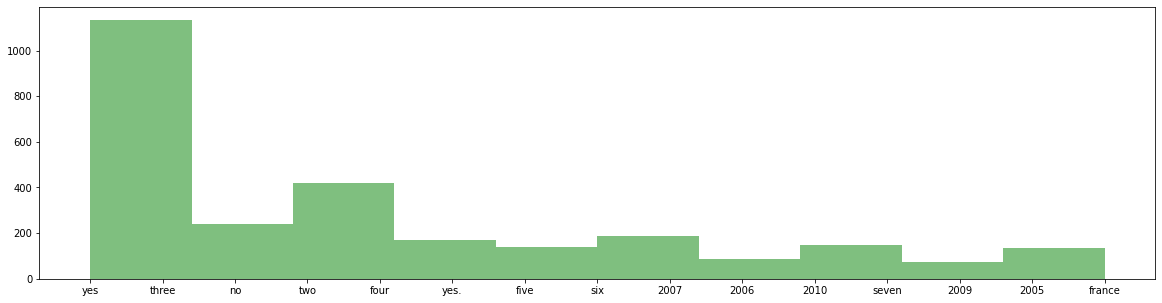

In [ ]:
import matplotlib
matplotlib.rc('figure', figsize=[20,5])
plt.hist(temp_reply_list, 10,
         histtype='bar',
         facecolor='g',
         alpha=0.5)
plt.show()

**Check the average length of the replies**

number of email don' have any reply : 0
**************************************************
Max length : 3
**************************************************
Min Length : 1
**************************************************
Average Length : 1.0416666666666667
**************************************************
unique replies in the data 155
--------------------------------------------------
Distribution of the words
--------------------------------------------------


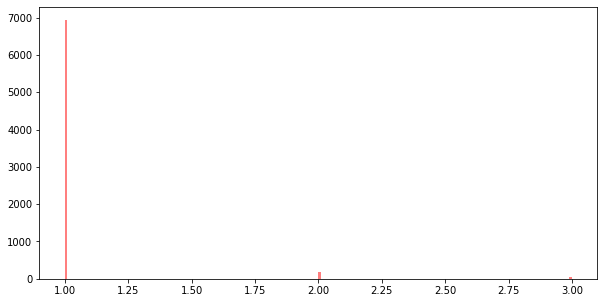

In [ ]:
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
#Getting the length of each Answer
len_answers = data["reply"].values
#len_answers = data["reply_length"].values

#converting datatype to string
len_str_arr = []
for sentence in len_answers:
  len_str_arr.append(len(sentence.split()))


temp_arr = []
for indx in len_answers:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)

no_reply_counter = 0 
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_str_arr)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(len_str_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_str_arr)))/(len(list(len_str_arr))))
print('*' * 50)


# need to get all the unique replies in the dataset
all_unique_replies = list(set(data['reply'].values))
print('unique replies in the data',len(all_unique_replies))


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

len_str_arr.sort()
plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

So here we are seeing the number of words in the replies 
are 1 only


Here we should have less unique replies but due to shortage of the data we can' remove more data from the data corpus

In [ ]:
#Here I'll try to use only the data where replies repeated for more then 5 times

**Check for emails/Question**

In [ ]:
all_questions = data['question'].values

In [ ]:

#Preprocessing Questions 
#Remove the full stops from the dataframe answers

bad_chars = [';', ':', '!', "*",'.',')','(','?']

preprocessed_question = []
for question in all_questions:
  for i in bad_chars : 
    question = question.replace(i, '')
  preprocessed_question.append(question)



**Words stemming**

In [ ]:
#Performing stammering here
# We are having less data
from nltk.stem import PorterStemmer
porter = PorterStemmer()
stemmed_sent = []
for sent in preprocessed_question:
  word_arr = []
  for word in sent.split():
    word_arr.append(porter.stem(word))
  temp_str = ""
  for words in word_arr:
    temp_str += words + " "
  stemmed_sent.append(temp_str)

data['question'] = stemmed_sent  

In [ ]:
#trimming the string the dataframe  
#because after removal of the special character trimming might have lost
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [ ]:
data.head()

,question,reply,q,reply_length,question_length,repeated_reply_count
2,when did beyonc leav destini s child and becom...,2003,nan,1,12,47
11,when did beyonc releas danger in love,2003,nan,1,7,47
12,how mani grammi award did beyonc win for her f...,five,nan,1,12,140
17,to set the record for grammi how mani did beyo...,six,nan,1,11,99
19,when did beyonc take a hiatu in her career and...,2010,nan,1,15,75


In [ ]:
len(data['question'].values[0].split())

12

number of email don' have any reply : 1
**************************************************
Max length : 229
**************************************************
Min Length : 2
**************************************************
Average Length : 52.312569676700114
**************************************************
No of unique questions : 152
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


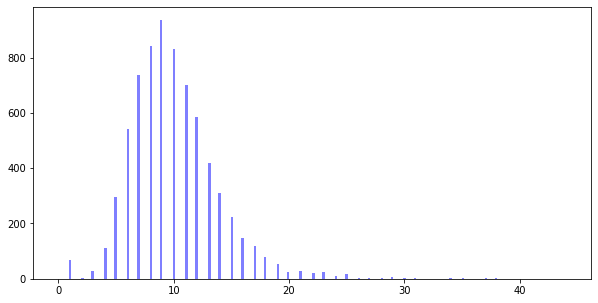

In [ ]:
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
#Getting the length of each Answer
len_questions = data["question"].str.len()

#converting datatype to string

len_str_arr = []
for data_ in data["question"].values:
  len_str_arr.append(len(data_.split()))


no_reply_counter = 0
for num in len_questions:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_questions:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_questions)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_questions)))/(len(list(len_questions))))
print('*' * 50)

print("No of unique questions", end = ' : ')
print(len(list(set(len_questions))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)
len_str_arr.sort()
plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

As we can see that number of maximum numner of words in  questions have 5 wordsw <br>
and most of them are in range 3-10

check maximum number of words in question 


**Feature Engineering**

In [19]:
# https://gist.github.com/sebleier/554280
#contains all the stop words this we'll use to count the stop words available in the question

stopwords_all = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't",'no', 'nor', 'not'])

In [20]:
#here we'll get the length of the sentence
# we need to get the length of the question here

len_str_arr = []
for sentence in data['question'].values:
  len_str_arr.append(len(sentence.split()))

data["question_length"]= len_str_arr


#Here we'll get the number of stop words in the sentences
stop_word_count = []
for sentence in data['question'].values:
  count = 0
  for words in sentence:
    if words in stopwords_all:
      count += 1
  stop_word_count.append(count)

data['question_stop_words'] = stop_word_count

# divide further for -ve and +ve stop words
# positive = 





#Here we'll take if days are there in the data corpus
#This will help in prediction of weekday easily

days = ['mon','tue','wed','thr','fri','sat','sun','sunday','monday','tuesday','wednesday','friday','thursday','saturday','sunday']    


days_in_data = []
for sentence in data['question'].values:
  count = 0
  for words in sentence:
    if words in days:
      count += 1
  days_in_data.append(count)

data['contains_days'] = days_in_data




#We can take tense also into concideration




NameError: name 'data' is not defined

#Data Preperation

So we'll repeat the replies after test and train bifercation else we'll get data leakage problem 

In [ ]:
data.head(2)

,question,reply,q,reply_length,question_length,repeated_reply_count,question_stop_words,contains_days
2,when did beyonc leav destini s child and becom...,2003,nan,1,12,47,24,0
11,when did beyonc releas danger in love,2003,nan,1,7,47,11,0


In [18]:
data = data.drop('q',axis= 1)

NameError: name 'data' is not defined

In [ ]:
data.head()

,question,reply,reply_length,question_length,repeated_reply_count,question_stop_words,contains_days
2,when did beyonc leav destini s child and becom...,2003,1,12,47,24,0
11,when did beyonc releas danger in love,2003,1,7,47,11,0
12,how mani grammi award did beyonc win for her f...,five,1,12,140,26,0
17,to set the record for grammi how mani did beyo...,six,1,11,99,22,0
19,when did beyonc take a hiatu in her career and...,2010,1,15,75,24,0


Let see which are top repeated replies 

In [ ]:
#Here we'll repeat the data set which are having less replies 

In [ ]:
## Similartly you can do preprocessing for review summary also.
#splitting the data(X and y) where X is the preprocessed reviews ad y is the score
X_Quest = data['question']
x_question_length = data['question_length']
x_question_stop_words = data['question_stop_words']
x_contains_days = data['contains_days']
y = data['reply']


In [ ]:
data.head()

,question,reply,reply_length,question_length,repeated_reply_count,question_stop_words,contains_days
2,when did beyonc leav destini s child and becom...,2003,1,12,47,24,0
11,when did beyonc releas danger in love,2003,1,7,47,11,0
12,how mani grammi award did beyonc win for her f...,five,1,12,140,26,0
17,to set the record for grammi how mani did beyo...,six,1,11,99,22,0
19,when did beyonc take a hiatu in her career and...,2010,1,15,75,24,0


In [17]:
X = data.drop('reply',axis = 1)

NameError: name 'data' is not defined

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    plt.savefig(name)
    plt.show()

In [16]:
#splitting the data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

NameError: name 'X' is not defined

In [ ]:
test = set(y_test.values)
train = set(y_train.values)
count = 0
for reply_test in test:
  for reply_train in train:
    if reply_train == reply_test:
      count += 1
      break;
print(count)

149


In [ ]:
len(test)

149

So we are having all the data(replies) which is there is test data are also avaialble in train data(replies)

#Here we'll repeat the replies for train set only

After this, We'll repeat the number of replies as we need less classification but more data so we'll check which reply is repeated how many times and will set an threshold to repeat the number of replies

Here we'll do upsampling of the data 

In [ ]:
reply_list = list(data['reply'].values)
reply_dict = {i:reply_list.count(i) for i in reply_list}

In [ ]:
from collections import OrderedDict
reply_dict_sorted = OrderedDict(sorted(reply_dict.items(), key=lambda x: x[1]))

In [ ]:
reply = []
keys = []
for item in reply_dict_sorted.items():
  reply.append(item[0])
  keys.append(item[1])

In [ ]:
reply.reverse()
keys.reverse()

In [ ]:
#top 10 reply
reply_ = reply[:]
keys_ = keys[:]

In [ ]:
res = dict(zip(reply_, keys_)) 
print(str(res))

{'yes': 886, 'three': 248, 'no': 241, 'two': 236, 'four': 183, 'yes.': 170, 'five': 140, 'six': 99, '2007': 88, '2006': 85, '2010': 75, 'seven': 74, '2009': 73, '2005': 70, 'france': 65, 'eight': 63, 'one': 61, '2013': 61, '2011': 59, '2004': 58, '2008': 55, '2012': 53, 'china': 50, 'nine': 50, 'paris': 50, 'french': 48, '2003': 47, 'germany': 46, '1991': 46, '2002': 46, 'english': 46, '2001': 45, '2014': 45, 'no.': 43, '20': 43, '19th': 40, '14': 40, 'latin': 39, '1994': 39, '1997': 39, '12': 39, '2015': 39, '1990': 38, '1999': 38, 'german': 37, '1992': 37, 'world war ii': 37, '1949': 37, 'united states': 37, 'london': 37, '1989': 36, '16': 36, '2000': 36, 'italy': 36, 'british': 35, '1968': 35, '10': 35, '1998': 34, 'greek': 34, '13': 34, 'europe': 34, 'white': 34, '30': 34, 'soviet union': 33, '19th century': 33, '1971': 33, 'japan': 33, 'spanish': 33, '1978': 32, '1979': 32, '1990s': 32, 'india': 32, '1995': 32, '1988': 31, 'ten': 31, 'russia': 30, '1960s': 30, '1950': 30, '15': 30

In [ ]:
df_concat = pd.concat([x_train, y_train], axis=1)

In [ ]:
df_concat.head(1)

,question,reply_length,question_length,repeated_reply_count,question_stop_words,contains_days,reply
80597,when were mosaic pavement uncov at the bizer m...,1,9,47,19,0,2003


In [ ]:
#We'll run for loop for every value and upsample every reply in the dataframe 
column_names = ['question','reply_length','repeated_reply_count','question_length','question_stop_words','contains_days','reply']
temp_df = pd.DataFrame(columns = column_names)
for item in tqdm(res):
  # get the this data from the dataframe 
    df_class = df_concat[df_concat['reply'] == item]
    df_over = df_class#.sample(100, replace=True)
    frames = [temp_df, df_over]
    temp_df = pd.concat(frames)




100%|██████████| 155/155 [00:00<00:00, 179.50it/s]


In [ ]:
#Here we checking the shape for theoversampled data
print(temp_df.shape)

#append yes replies too in the temp_df, as we ignored yes there in the above 

df_yes_reply = df_concat[df_concat['reply'] == 'yes']

frame = [df_yes_reply,temp_df]

upsample_data = pd.concat(frame)

(6458, 7)


In [ ]:
upsample_data.shape

(7255, 7)

so now we increased dataset from 7K to 121K

Again we need to divide the dataframe into x_train and y_train

In [ ]:
x_train = upsample_data.drop('reply',axis = 1)
y_train = upsample_data['reply']

In [ ]:
 words = []
for text in x_train['question'].values:
  words += text.split()

In [ ]:
from collections import Counter
count = Counter(words)

In [ ]:
type(count)

collections.Counter

In [ ]:
#Taking only top 5K data 
sorted_words_arr = count.most_common(5000)

In [ ]:
sorted_arr = []
for index in range(0,len(sorted_words_arr)):
  sorted_arr.append(sorted_words_arr[index][0])


In [ ]:
sentGlobal = []
for sentence in x_train['question'].values:
  words_Local = []
  for words in sentence.split():
    if words in sorted_arr:
      words_Local.append(sorted_arr.index(words) + 1)

  sentGlobal.append(words_Local)



In [ ]:
sentGlobal_test = []
for sentence in x_test['question'].values:
  words_Local = []
  for words in sentence.split():
    if words in sorted_arr:
      words_Local.append(sorted_arr.index(words) + 1)

  sentGlobal_test.append(words_Local)



In [ ]:
x_train_question = sentGlobal
x_test_question = sentGlobal_test

In [ ]:
# truncate and/or pad input sequences
from keras.preprocessing import sequence
#As maximum length is 9 we'll take 10 as maximum review length
max_review_length = 10
#Here we padded the sentence and truncated at the end. 
X_train_quest = sequence.pad_sequences(x_train_question, maxlen=max_review_length,padding='post',truncating='post',value=0)
X_test_quest = sequence.pad_sequences(x_test_question, maxlen=max_review_length,padding='post',truncating='post',value=0)
print(X_train_quest.shape)

(7255, 10)


Here we need to tokenize the (full sentence) into 1 token for the test data<br>
We need all the unique setences available in the data and create a matrix where we an mark which reply is in which position

In [ ]:
tokenized_reply_sentences = []
# need to get all the unique replies in the dataset
all_unique_replies = list(set(y.values))
print('unique replies in the data',len(all_unique_replies))

NameError: name 'y' is not defined

In [ ]:
y_train.shape[0]

7255

So we exact same number of replies in our data set 

In [ ]:
output_words = sorted(list(all_unique_replies))# this replies are coming from train data only 
# from word to token we can get
output_token_index = dict([(word, i+1) for i, word in enumerate(output_words)])
reverse_output_index = dict((i, word) for word, i in output_token_index.items())

NameError: name 'all_unique_replies' is not defined

In [ ]:
def generate_batch(X,y, batch_size):
    while True:
        for j in range(0, len(X), batch_size):
                    rows,cols = (len(X),(len(list(set(data['reply'].values)))+1)) 
                    output_data = np.zeros((rows, cols),dtype='float32')
                    for (i, (input_text, target_text)) in enumerate(zip(X[j:j+ batch_size], y[j:j + batch_size])):
                        #creatinf 2D matrix for thr replies
                        output_data[i,output_token_index[target_text]] = 1
                    return output_data

In [ ]:
Y_train = generate_batch(X_train_quest,y_train,len(X_train_quest))  
Y_test = generate_batch(X_test_quest,y_test,len(X_test_quest))

In [ ]:
Y_train.shape

(7255, 156)

In [ ]:
#For question text we'are embedding
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Concatenate,TimeDistributed
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate,Embedding,RepeatVector


In [ ]:
#Question Length

input_data_question_length = Input(shape=(1,),name="question_length")
# layer_question_length = Embedding(42,42,trainable=True)(input_data_question_length)
x = BatchNormalization()(input_data_question_length)
flattened_question_length = Dense(128, activation='relu')(x)
# flattened_question_length = input_data_question_length#Flatten()(input_data_question_length)

In [ ]:
#Question stop words
input_data_question_stop_words = Input(shape=(1,),name="question_stop_words")
# layer_question_stop_words = Embedding(74,74,trainable=True)(input_data_question_stop_words)
x = BatchNormalization()(input_data_question_stop_words)
x = Dropout(0.3)(x)
flattened_question_stop_words = Dense(128, activation='relu')(x)
# flattened_question_stop_words = (input_data_question_stop_words)#Flatten()(layer_question_stop_words)

In [ ]:

#Question contains days
input_data_question_contains_days = Input(shape=(1,),name="contains_days")
# layer_question_contains_days = Embedding(1,1,trainable=True)(input_data_question_contains_days)
x = BatchNormalization()(input_data_question_contains_days)
flattened_question_contains_days = Dense(128, activation='relu')(x)
# flattened_question_contains_days =  (input_data_question_contains_days)#Flatten()(input_data_question_contains_days)

In [ ]:


embedding_vecor_length = 64
max_review_length = 10
vocab_len = len(output_token_index)
 # how much dimension of output we want form the embedding layer
encoder_inputs = Input(shape=(None,)) # mentioning the input shape row and collumns are still null
# model = Sequential()
# model.add(Embedding(vocab_len + 1, latent_dim, input_length=vocab_len))
# model.add(Embedding(vocab_len + 1, embedding_vecor_length, input_length=max_review_length))

NameError: name 'output_token_index' is not defined

In [ ]:
from keras.layers.recurrent import LSTM
input_text =  Input(shape=(None,),name="input_text")
# try batch normaization here // it;ll be according to word i guess
embedded_layer = Embedding(vocab_len + 1, embedding_vecor_length, input_length=max_review_length)
x = embedded_layer(input_text)
x = Bidirectional(LSTM(128,return_sequences=True))(x)
x = BatchNormalization()(x)
# x = Bidirectional(LSTM(64,return_sequences=True))(x)
x = Dropout(0.2)(x) 
x = LSTM(64,return_sequences=True)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = LSTM(256,return_sequences=True)(x)
flatted_text = Flatten()(Dense(128,activation="relu",kernel_initializer="he_normal")(x))

In [ ]:
from sklearn.metrics import f1_score
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model, load_model
#concatinating 


data = concatenate([flattened_question_length ,flattened_question_stop_words,    flatted_text])
data = Dense(256,activation="relu",kernel_initializer="he_normal")(data)

data = Dropout(0.3)(data) 
data = BatchNormalization()(data)
data = Dense(256,activation="relu",kernel_initializer="he_normal")(data)
data = Dropout(0.2)(data)
data = BatchNormalization()(data)
data = Dense(512,activation="relu",kernel_initializer="he_normal")(data)
data = Dropout(0.1)(data)
 
outputs = Dense(156, activation='softmax')(data)
model = Model(inputs = [input_data_question_length,   input_data_question_stop_words,  input_text],outputs= outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m,precision_m, recall_m])

NameError: name 'flattened_question_length' is not defined

In [ ]:
train_model = [x_train['question_length'],x_train['question_stop_words'],X_train_quest]#,   label_encoder_train_sub_sub_category,   label_encoder_train_sub_category,     label_encoder_train_grade    ,label_encoder_train_teacher_prefix   ,label_encoder_train]

test_model = [x_test['question_length'],x_test['question_stop_words'],X_test_quest]#,   label_encoder_test_sub_sub_category,   label_encoder_test_sub_category,     label_encoder_test_grade    ,label_encoder_test_teacher_prefix   ,label_encoder_test]


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: cannot import name 'plot_model' from 'keras.utils' (C:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\__init__.py)

In [ ]:
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
from keras.callbacks import ModelCheckpoint

In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [ ]:
# LOG_DIR = './log'
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )

In [ ]:
# get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:

# from keras.callbacks import TensorBoard
# batch_size=20
# tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
#                          write_graph=True,
#                          write_grads=True,
#                          batch_size=batch_size,
#                          write_images=True)

In [ ]:
# istory = model.fit(train_model,Y_train,batch_size=30,epochs=120,validation_data=(test_model,Y_test),verbose=1)
history = model.fit(train_model,Y_train,batch_size=350,epochs=60,validation_data=(test_model,Y_test),verbose=1)

NameError: name 'model' is not defined

In [ ]:
(type(X_train_quest)

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_15628/467500536.py, line 1)

In [ ]:
#loss graph
%matplotlib inline
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.legend({'loss_train': 'b', 'loss_test':'g'})
plt.show()

NameError: name 'history' is not defined

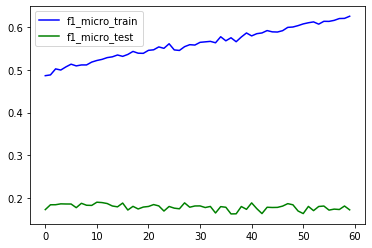

In [ ]:
#auc_roc graph
plt.legend({'train_roc_auc': 'b', 'test_roc_auc':'g'})
plt.plot(history.history['f1_m'], 'b')
plt.plot(history.history['val_f1_m'], 'g')
plt.legend({'f1_micro_train': 'b', 'f1_micro_test':'g'})
plt.show()

In [ ]:
import pickle
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
import pickle
filename = 'history'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
pred = model.predict(test_model)

In [ ]:
counter = 0
accuracy_counter_test = 0
for index in range(0,50):
  counter += 1
  print("Question",counter)
  print(x_test['question'].values[index])
  print("\n")
  print("real answer")
  p_0 = np.argmax(Y_test[index])
  print(reverse_output_index[p_0])
  print("\n")
  print("predicted Answers")
  p_1 = np.argmax(pred[index])
  token1 = reverse_output_index[p_1]
  print(token1)
  pred[index][p_1] = 0
  p_2 = np.argmax(pred[index])
  token2 = reverse_output_index[p_2]
  print(token2)
  pred[index][p_2] = 0
  p_3 = np.argmax(pred[index])
  token3 = reverse_output_index[p_3]
  print(token3)
  pred[index][p_3] = 0
  print("\n")
  print("*"*8)

  

Question 1
how mani major medic school doe london boast


real answer
five


predicted Answers
three
two
four


********
Question 2
which confeder cup did brasilia host


real answer
2013


predicted Answers
2014
1936
1954


********
Question 3
what percentag of children in a survey of peopl in hyderabad were underweight


real answer
20%


predicted Answers
25%
10%
20%


********
Question 4
in what year were big chang made to the ansi


real answer
1960


predicted Answers
1959
1967
1984


********
Question 5
how mani region health administr exist in portug


real answer
five


predicted Answers
six
five
two


********
Question 6
are there mani roma in romania


real answer
no


predicted Answers
no.
no
yes.


********
Question 7
how mani polic district wa pari divid into


real answer
16


predicted Answers
two
three
four


********
Question 8
in what year wa a statu dedic to freddi mercuri unveil in montreux


real answer
1996


predicted Answers
1962
2009
2011


********
Question 9

#Conclusion

Here I got less accuracy in for the test but more accuracy for the train, <br>
as in train dataset I oversampled the data which helped in getting more accuracy for the train dataset <br>
But the test data set is not oversampled 
<br>
<b> Even though the accuracy is less but see the answers above they are nearly the same intention <b>
<br>

<b> as model can't predict aptitute answers it tried to predict best of it <b>




F1 Micro score

for train it's 0.63 

for test it's 0.2111

Loss Score

for train it's 0.4105 <br>
for test it's 6.98

Why I choosed the above approach

I choosed above approach <b>(Multiclassification) not enocoder-decoder</b> as dataset is less and the chances of gramatical errors are more<br>
and we need to predict short answers not long answers , as most of the suggestions are short in reality<br>
<b>(Inspired from linkedin approach)</b>


How the Things Worked

1. Loaded the data from multiple source and combined them all<br>
2. We preprocessed the train data <br>
3. took only the data which are repeated more than 20 times in the dataset which helped in less multiclassification 
and other thing is it helped in getting better grammar,as mostly reapeated questions will have better grammar
4. because of previous step we got 155 multiclasses 
5. Divided the data into test and train 
6. Oversampled the train dataset on less repeated question which wil help in increasing the dataset and not let it biased towards more repeated answers
7. did feature engineering ( Days, Stop words and question length)
8. Predicted for the test dataset 

<h3>Conclusions:</h3>
 </br> 
LSTM with 1 layer is much simmilar to Layer 2 LSTM, No Drastic change in the accuracy </br> </br>
LSTM with 2 layer took much more time compared to LSTM with 1 layer  without much change in accuracy</br></br>
LSTM Worked Much better from all the previous models from ML as well as other NLP deep learning model </br> </br>
LSTM have 3 layers operation inside it  </br> </br>
LSTM is better form of Simple RNN </br> </br>


<center> LSTM </center>
</br>
<b> 1st we got the data from and we preprocessed it </b></br>
<b> 2nd we took the data(Sentences) and divided in train and test </b>
</br>
<b>3rd then we spliiteded the sentense into words </b>
</br>
<b> 4th we sorted thw words based on their occurance  and replaced it with the rank from 1- n </b>
</br>
<b>5th we choosed only top 5000 words from the ranking and words </b>
</br>
<b>6th change the words with ranks in x_test and x_train data </b>
</br>
<b>7th We'll take all sentence of same size so that batch can be created other wise it'll be very slow</b>
</br>
<b>8th created batch as input </b>
</br>
<b>9th Train a LSTM layer </b>
</br> </br></br> </br></br> </br>
<center> <h2>How LSTM Works </h2></b> </br></br>
In LSTM 
we pass the input to layer 1 and it recur multiple times , with function time 
LSTM has 3 layers inside it</br> <b>
Input ,output,forget</b>  </br></br>
x and + are there which help me carring the data to further layer (like ResNet Skipping) so that original data can be preserved and if some data model didn' learn can be passed foward so that next time it may learn and can pass data to another layer without the loss 

</br></br>

when we get the input as the output form previous interation or layer and the data as inout the we combine them and pass it throught sigmoid function which will (Ft) which tell how much to remember and forget it goes to (x)

</br></br>

and again now we thanwe take same input to previous sigmoid fucntiona  pass it to sigmoid and tanh and perform binary multiplication of output form sigmoid and tanh ( this tell how much input should impact the output of the layer)

</br> </br>

and the out put from previous layer is binary added to the output line 
</br></br>
the again we put signoid layer which take (WiYt concated with w(Ot-1)) and goes to sigmoid layer and binary multiplied with the tanh of the ooutput line and give output as Yit which passes to another layer or to same with new iteration
</br></br>



Reference taken from https://cs224d.stanford.edu/reports/ZhouXu.pdf </center>



in above models we tried multiple LSTM layers and neurons to train it better and get best output